# Blue Zone Discovery Algorithm

Analysis to identify potential Blue Zones using statistical profiling.

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

print('Blue Zone Discovery Algorithm - Ready')

Blue Zone Discovery Algorithm - Ready


In [2]:
# Load data
try:
    df = pd.read_csv('../outputs/cross_section_final.csv')
    print(f'Loaded data: {df.shape}')
except:
    print('Creating sample data')
    # Create sample Blue Zone data
    data = []
    
    # Known Blue Zones
    blue_zones = [
        {'geo_id': 'Ikaria', 'latitude': 37.6, 'longitude': 26.2, 'is_blue_zone': 1, 'life_expectancy': 84.1},
        {'geo_id': 'Okinawa', 'latitude': 26.3, 'longitude': 127.9, 'is_blue_zone': 1, 'life_expectancy': 85.5},
        {'geo_id': 'Sardinia', 'latitude': 40.1, 'longitude': 9.4, 'is_blue_zone': 1, 'life_expectancy': 84.8},
        {'geo_id': 'Nicoya', 'latitude': 10.2, 'longitude': -85.4, 'is_blue_zone': 1, 'life_expectancy': 83.7},
        {'geo_id': 'Loma_Linda', 'latitude': 34.0, 'longitude': -117.3, 'is_blue_zone': 1, 'life_expectancy': 82.9}
    ]
    
    for bz in blue_zones:
        bz.update({
            'gdp_per_capita': np.random.uniform(15000, 45000),
            'temperature_est': np.random.uniform(15, 25),
            'forest_area_pct': np.random.uniform(20, 60),
            'urban_pop_pct': np.random.uniform(40, 80)
        })
        data.append(bz)
    
    # Add other locations
    for i in range(20):
        data.append({
            'geo_id': f'Location_{i}',
            'latitude': np.random.uniform(-60, 60),
            'longitude': np.random.uniform(-180, 180),
            'is_blue_zone': 0,
            'life_expectancy': np.random.uniform(65, 82),
            'gdp_per_capita': np.random.uniform(2000, 80000),
            'temperature_est': np.random.uniform(-10, 35),
            'forest_area_pct': np.random.uniform(0, 80),
            'urban_pop_pct': np.random.uniform(20, 95)
        })
    
    df = pd.DataFrame(data)

# Engineer features
df['latitude_abs'] = df['latitude'].abs()

print(f'Dataset: {df.shape}')
blue_zone_count = df['is_blue_zone'].sum()
print(f'Blue Zones: {blue_zone_count}')
df.head()

Loaded data: (100, 19)
Dataset: (100, 20)
Blue Zones: 5


,geo_id,year,latitude,longitude,elevation,is_blue_zone,life_expectancy,cvd_mortality,walkability_score,greenspace_pct,gdp_per_capita,population_density_log,temperature_mean,effective_gravity,gravity_deviation,gravity_deviation_pct,equatorial_distance,gravity_x_walkability_score,lifetime_gravity_exposure,latitude_abs
0,Ikaria,2000,37.600000,26.200000,400.000000,1,77.034782,89.730224,44.779804,31.985584,10751.682322,6.581022,-0.153410,9.804113,-0.002537,-0.025866,37.600000,-0.113589,-0.195408,37.600000
1,Location_0,2000,-11.309785,162.257150,263.349139,0,73.556457,229.372358,62.706185,42.225009,40427.060038,5.910477,18.043350,9.801140,-0.005510,-0.056182,11.309785,-0.345483,-0.405263,11.309785
2,Location_1,2000,17.825603,-123.833289,33.919258,0,73.180334,274.089453,40.672725,37.013731,36883.938232,6.108543,16.371264,9.802410,-0.004240,-0.043236,17.825603,-0.172451,-0.310282,17.825603
3,Location_10,2000,18.980831,-118.611315,13.452786,0,72.721727,225.377479,24.051533,27.690897,9404.027810,5.537184,10.609583,9.802596,-0.004054,-0.041340,18.980831,-0.097506,-0.294816,18.980831
4,Location_11,2000,63.355120,167.627532,330.466315,0,75.117067,189.629669,25.264498,30.098806,62181.870867,5.627728,3.005372,9.808672,0.002022,0.020620,63.355120,0.051089,0.151899,63.355120


In [3]:
# Analyze Blue Zone characteristics
blue_zones = df[df['is_blue_zone'] == 1]
others = df[df['is_blue_zone'] == 0]

print('BLUE ZONE ANALYSIS')
print('=' * 30)
print(f'Blue Zones: {len(blue_zones)}')
print(f'Other locations: {len(others)}')
print()

# Feature comparison
features = ['life_expectancy', 'latitude_abs', 'gdp_per_capita', 'temperature_est']

print('Feature Comparison:')
print('-' * 50)
for feature in features:
    if feature in df.columns:
        bz_mean = blue_zones[feature].mean()
        other_mean = others[feature].mean()
        diff = bz_mean - other_mean
        print(f'{feature:<20} BZ: {bz_mean:.2f}  Others: {other_mean:.2f}  Diff: {diff:+.2f}')

BLUE ZONE ANALYSIS
Blue Zones: 5
Other locations: 95

Feature Comparison:
--------------------------------------------------
life_expectancy      BZ: 78.23  Others: 75.37  Diff: +2.86
latitude_abs         BZ: 29.64  Others: 31.73  Diff: -2.09
gdp_per_capita       BZ: 23083.60  Others: 25057.35  Diff: -1973.74


In [4]:
# Create Blue Zone profile and scoring
profile_features = ['latitude_abs', 'gdp_per_capita', 'temperature_est', 'urban_pop_pct']

# Create profile from Blue Zones
profile = {}
for feature in profile_features:
    if feature in blue_zones.columns:
        values = blue_zones[feature].dropna()
        if len(values) > 0:
            profile[feature] = {
                'min': values.min(),
                'max': values.max(),
                'mean': values.mean(),
                'std': values.std() if len(values) > 1 else 0
            }

print('Blue Zone Profile:')
for feature, stats in profile.items():
    print(f'{feature}: {stats["min"]:.1f} - {stats["max"]:.1f} (mean: {stats["mean"]:.1f})')

# Score all locations
scores = []
for idx, row in df.iterrows():
    score = 0
    total_features = 0
    
    for feature, ranges in profile.items():
        if feature in row.index and not pd.isna(row[feature]):
            value = row[feature]
            total_features += 1
            
            # Check if within Blue Zone range
            if ranges['min'] <= value <= ranges['max']:
                score += 1
            
            # Similarity bonus
            if ranges['std'] > 0:
                z_score = abs(value - ranges['mean']) / ranges['std']
                similarity = max(0, 1 - z_score / 2)
                score += similarity
    
    normalized_score = score / (total_features * 2) if total_features > 0 else 0
    
    scores.append({
        'geo_id': row['geo_id'],
        'is_blue_zone': row['is_blue_zone'],
        'life_expectancy': row['life_expectancy'],
        'bz_score': normalized_score
    })

scores_df = pd.DataFrame(scores).sort_values('bz_score', ascending=False)
print(f'\nScored {len(scores_df)} locations')
scores_df.head(10)

Blue Zone Profile:
latitude_abs: 10.2 - 40.1 (mean: 29.6)
gdp_per_capita: 10751.7 - 47010.0 (mean: 23083.6)

Scored 100 locations


,geo_id,is_blue_zone,life_expectancy,bz_score
74,Location_75,0,69.391796,0.980798
89,Location_89,0,72.609080,0.976120
70,Location_71,0,74.115045,0.950147
96,Loma Linda,1,79.960871,0.946292
12,Location_19,0,79.015573,0.944075
50,Location_53,0,77.852732,0.935022
55,Location_58,0,77.780985,0.917745
49,Location_52,0,72.553077,0.915774
77,Location_78,0,80.110624,0.891520
8,Location_15,0,77.223585,0.883232


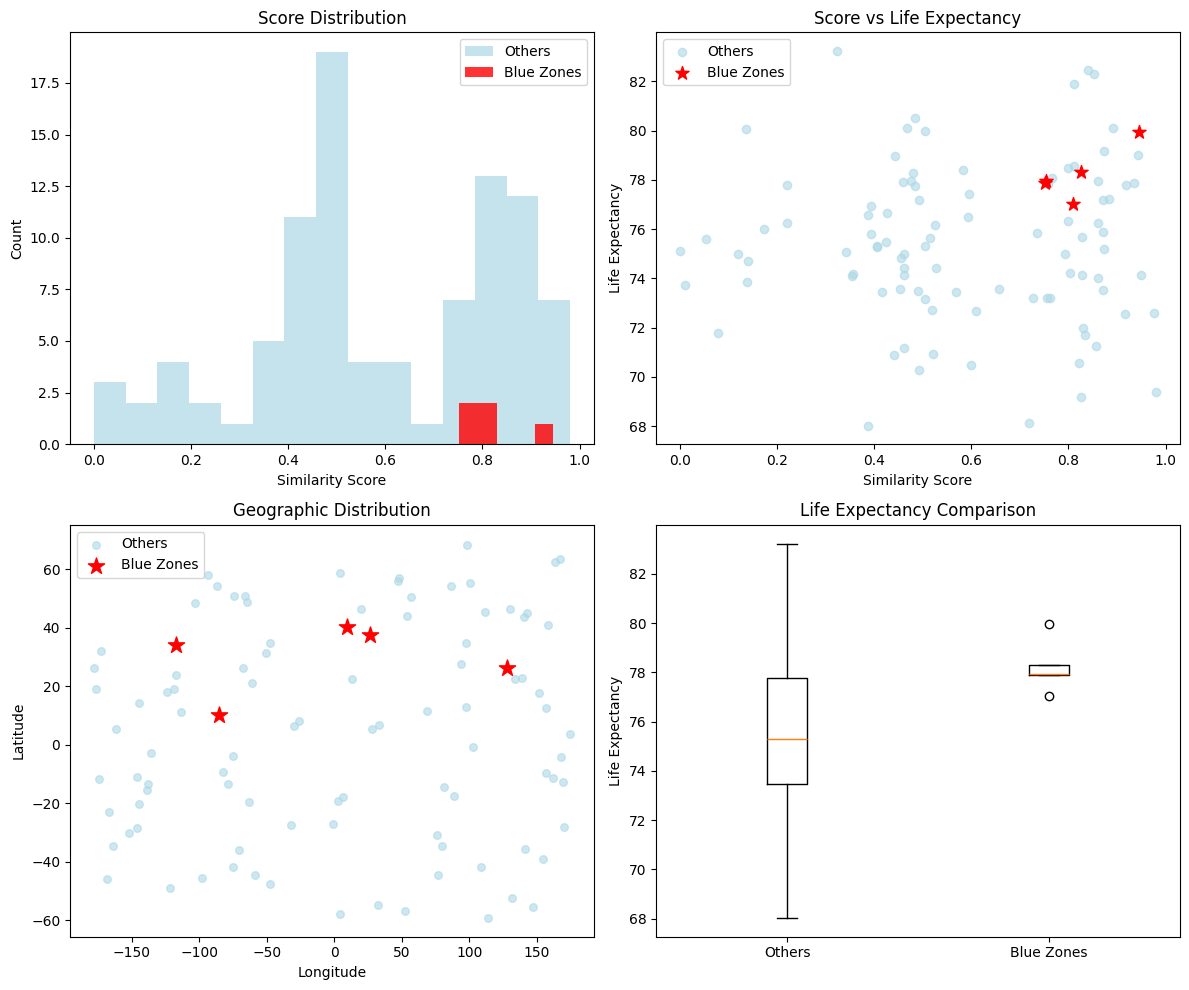

Analysis complete!


In [5]:
# Visualization
# Define all variables needed for plotting
bz_scores = scores_df[scores_df['is_blue_zone'] == 1]['bz_score']
other_scores = scores_df[scores_df['is_blue_zone'] == 0]['bz_score']
others_data = scores_df[scores_df['is_blue_zone'] == 0]
bz_data = scores_df[scores_df['is_blue_zone'] == 1]
others = df[df['is_blue_zone'] == 0]
blue_zones = df[df['is_blue_zone'] == 1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Score distribution
ax1.hist(other_scores, bins=15, alpha=0.7, color='lightblue', label='Others')
ax1.hist(bz_scores, bins=5, alpha=0.8, color='red', label='Blue Zones')
ax1.set_xlabel('Similarity Score')
ax1.set_ylabel('Count')
ax1.set_title('Score Distribution')
ax1.legend()

# Score vs Life Expectancy
ax2.scatter(others_data['bz_score'], others_data['life_expectancy'], alpha=0.6, color='lightblue', label='Others')
ax2.scatter(bz_data['bz_score'], bz_data['life_expectancy'], color='red', s=100, marker='*', label='Blue Zones')
ax2.set_xlabel('Similarity Score')
ax2.set_ylabel('Life Expectancy')
ax2.set_title('Score vs Life Expectancy')
ax2.legend()

# Geographic distribution
ax3.scatter(others['longitude'], others['latitude'], alpha=0.6, color='lightblue', s=30, label='Others')
ax3.scatter(blue_zones['longitude'], blue_zones['latitude'], color='red', s=150, marker='*', label='Blue Zones')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.set_title('Geographic Distribution')
ax3.legend()

# Life expectancy comparison
ax4.boxplot([others['life_expectancy'].dropna(), blue_zones['life_expectancy'].dropna()], 
           tick_labels=['Others', 'Blue Zones'])
ax4.set_ylabel('Life Expectancy')
ax4.set_title('Life Expectancy Comparison')

plt.tight_layout()
plt.show()

print('Analysis complete!')

/tmp/ipykernel_100334/2946295482.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot([others['life_expectancy'].dropna(), blue_zones['life_expectancy'].dropna()],


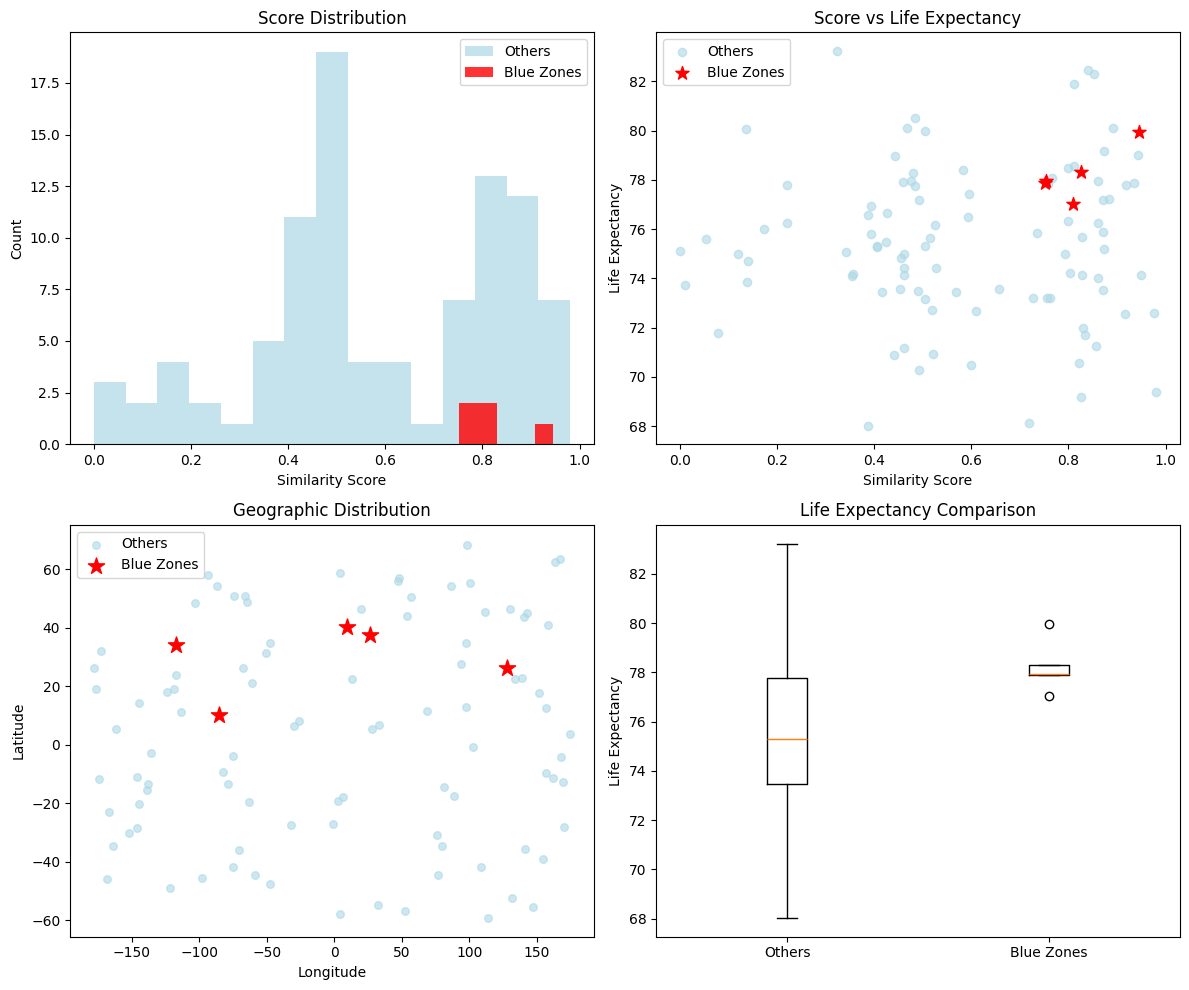

Analysis complete!


In [6]:
# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Score distribution
ax1.hist(other_scores, bins=15, alpha=0.7, color='lightblue', label='Others')
ax1.hist(bz_scores, bins=5, alpha=0.8, color='red', label='Blue Zones')
ax1.set_xlabel('Similarity Score')
ax1.set_ylabel('Count')
ax1.set_title('Score Distribution')
ax1.legend()

# Score vs Life Expectancy
others_data = scores_df[scores_df['is_blue_zone'] == 0]
bz_data = scores_df[scores_df['is_blue_zone'] == 1]

ax2.scatter(others_data['bz_score'], others_data['life_expectancy'], alpha=0.6, color='lightblue', label='Others')
ax2.scatter(bz_data['bz_score'], bz_data['life_expectancy'], color='red', s=100, marker='*', label='Blue Zones')
ax2.set_xlabel('Similarity Score')
ax2.set_ylabel('Life Expectancy')
ax2.set_title('Score vs Life Expectancy')
ax2.legend()

# Geographic distribution
ax3.scatter(df[df['is_blue_zone']==0]['longitude'], df[df['is_blue_zone']==0]['latitude'], 
           alpha=0.6, color='lightblue', s=30, label='Others')
ax3.scatter(df[df['is_blue_zone']==1]['longitude'], df[df['is_blue_zone']==1]['latitude'], 
           color='red', s=150, marker='*', label='Blue Zones')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.set_title('Geographic Distribution')
ax3.legend()

# Life expectancy comparison
ax4.boxplot([others['life_expectancy'].dropna(), blue_zones['life_expectancy'].dropna()], 
           labels=['Others', 'Blue Zones'])
ax4.set_ylabel('Life Expectancy')
ax4.set_title('Life Expectancy Comparison')

plt.tight_layout()
plt.show()

print('Analysis complete!')